# Instrument Selection

Before you think about *how* you trade you need to consider *what* you're going to trade- the actual instruments to buy or sell. 

The purpose of this notebook is to go over:
 - [Necessities](#Necessities): The minimum requirements that need to be met before you can trade an instrument
 - [Instrument choice and trading style](#Instrument-choice-and-trading-style): Characteristics that influence instrument choice between alternatives and how to trade particular instruments
 - [Access](#Access): Different ways to get exposure to instruments, and the benefits and downsides of each
 

In [256]:
import json
import requests 
from datetime import date, datetime, timedelta
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('display.notebook_repr_html', True)

%matplotlib inline 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(rc={"figure.figsize": (20, 10)}) 

from cryptocompare import get_daily_trades
import plot

## Necessities 

- [ ] [Data availability](#Data) 
 - [ ] At a minimum you need daily price data to trade an insturment systematically. For fundamental strategies you also need other relevant data, e.g. price:earnings if you're using an equity value rule.
- [ ] Minimum sizes 
 - [ ] For small investors large minimum trading sizes can be a problem.
- [ ] Why do prices move?
 - [ ] Don't trade from an ivory tower: have some idea of the factors driving returns. If unusual forces are at play then avoid the instrument. 
- [ ] Standard deviation
 - [ ] Volatility must not be extremely low.

#### [Poloniex](https://poloniex.com/support/api/)
- returnChartData
- returnTickers
- returnOrderbook
- returnLoanOrders

In [12]:
def poloniex_api(command, args={}):
    url = 'https://poloniex.com/public?command='+command
    for arg, value in args.items():
        url += '&{}={}'.format(arg,value)
    return json.loads(requests.get(url).content.decode('utf-8'))

In [52]:
tickers = pd.DataFrame(poloniex_api('returnTicker')).T.reset_index().rename(columns={'index': 'market'})
tickers.shape

(111, 11)

In [63]:
tickers['baseAsset'], tickers['quoteAsset'] = zip(*tickers.market.str.split('_'))
tickers.head()

,market,baseVolume,high24hr,highestBid,id,isFrozen,last,low24hr,lowestAsk,percentChange,quoteVolume,quoteAsset,baseAsset,usdVolume
0,BTC_BCN,92.714412,3.000000e-07,2.800000e-07,7.0,0.0,2.900000e-07,2.700000e-07,2.900000e-07,0.000000,3.264766e+08,BCN,BTC,2.117684e+12
1,BTC_BTCD,1.635937,9.350000e-03,8.706630e-03,12.0,0.0,8.879430e-03,8.000000e-03,8.879430e-03,-0.010099,1.892674e+02,BTCD,BTC,1.227679e+06
2,BTC_BTM,1.104916,2.094000e-05,1.926000e-05,13.0,0.0,1.966000e-05,1.908000e-05,1.964000e-05,-0.049323,5.490548e+04,BTM,BTC,3.561433e+08
3,BTC_BTS,52.213315,1.747000e-05,1.713000e-05,14.0,0.0,1.720000e-05,1.545000e-05,1.720000e-05,0.092063,3.145915e+06,BTS,BTC,2.040592e+10
4,BTC_BURST,1.636060,1.630000e-06,1.580000e-06,15.0,0.0,1.580000e-06,1.530000e-06,1.590000e-06,-0.012500,1.036376e+06,BURST,BTC,6.722429e+09


In [54]:
for col in tickers.columns: 
    if col not in ['quoteAsset','baseAsset', 'market']:
        tickers[col] = tickers[col].astype(float)

In [64]:
tickers.baseAsset.unique()

array(['BTC', 'USDT', 'XMR', 'ETH'], dtype=object)

In [65]:
len(tickers.quoteAsset.unique())

64

In [66]:
prices = {a: get_daily_trades(a, from_file=True).close[-1] for a in tickers.baseAsset.unique()}
prices

{'BTC': 6486.48, 'USDT': 0.9994, 'XMR': 114.03, 'ETH': 216.31}

In [70]:
# convert prices to usd 
tickers['usdVolume'] = tickers.apply(lambda t: prices[t.baseAsset] * t.baseVolume, axis=1)

In [71]:
tickers.set_index('market').usdVolume.sort_values(ascending=False).reset_index()

,market,usdVolume
0,BTC_ETH,1.243304e+07
1,USDT_BTC,5.696979e+06
2,USDT_ETH,5.692446e+06
3,BTC_DOGE,3.040124e+06
4,BTC_XRP,1.544422e+06
5,BTC_XMR,1.320316e+06
6,USDT_BCH,1.092746e+06
7,BTC_LTC,1.055965e+06
8,USDT_ETC,9.630187e+05
9,BTC_STR,9.310095e+05


In [72]:
filtered_markets = tickers[tickers.usdVolume > 2.5e5]
filtered_markets.shape

(23, 14)

In [78]:
import time
def unix_time(dt):
    return int(time.mktime(dt.timetuple()))

In [91]:
start = datetime(2008,1,1)
end = datetime.now()#(2017,1,2)
period_inteval = timedelta(minutes=15)
trades = {}
for market in filtered_markets.market:
    print(market)
    print('-'*50)
    trades[market] = pd.DataFrame(poloniex_api('returnChartData', {
                'currencyPair': market,
                'start': unix_time(start),
                'end': unix_time(end),
                'period': period_interval.seconds
            }))
    trades[market]['date'] = pd.to_datetime(trades[market]['date'] * 1e9)
    trades[market] = trades[market].set_index('date')
    trades[market].to_csv('price_data/POLONIEX_{}'.format(market))
    print('{} - {} ({} samples)'.format(
        trades[market].index.min(), 
        trades[market].index.max(),
        trades[market].shape[0]
    ))
    print('='*50)
    time.sleep(1)

BTC_BCN
--------------------------------------------------
2014-05-20 23:00:00 - 2018-09-14 19:45:00 (151476 samples)
BTC_BTS
--------------------------------------------------
2014-08-16 01:45:00 - 2018-09-14 19:45:00 (143113 samples)
BTC_DASH
--------------------------------------------------
2014-02-07 20:30:00 - 2018-09-14 19:45:00 (161278 samples)
BTC_DGB
--------------------------------------------------
2015-02-09 20:45:00 - 2018-09-14 19:45:00 (126045 samples)
BTC_DOGE
--------------------------------------------------
2014-01-21 22:45:00 - 2018-09-14 19:45:00 (162901 samples)
BTC_LTC
--------------------------------------------------
2014-01-18 04:15:00 - 2018-09-14 19:45:00 (163263 samples)
BTC_STR
--------------------------------------------------
2014-08-11 18:30:00 - 2018-09-14 19:45:00 (143526 samples)
BTC_XMR
--------------------------------------------------
2014-05-19 05:30:00 - 2018-09-14 19:45:00 (151642 samples)
BTC_XRP
----------------------------------------------

### Instrument choice and trading style 
- How many instuments?
 - Given the size of your account and the minimum size of each instrument you can determine wheather you will run into problems given a particular sized portfolio. You should then hold the largest portfolio you can given those constraints.
 
Our portfolio currently contains $250k

In [93]:
250e3 / len(trades)

10869.565217391304

- Liquidity
 - For larger and less patient investors liquidity is vital.

In [130]:
volume = pd.DataFrame()
for market in trades:
    baseAsset, quoteAsset = market.split('_')
    data = trades[market]
    volume[market] = data.groupby(data.index.date).volume.sum()
    timeFrame = volume[market].index
    basePrice = get_daily_trades(baseAsset, from_file=True).close[timeFrame.min():timeFrame.max()]
    volume[market] = volume[market] * basePrice

In [212]:
volume.describe().T['25%'].sort_values(ascending=False)#.plot(kind='bar')

BTC_ETH      2.950228e+06
USDT_BCH     1.391897e+06
BTC_BCH      1.320738e+06
BTC_ETC      6.870128e+05
BTC_ZEC      5.395011e+05
USDT_EOS     1.558286e+05
USDT_ETC     1.389752e+05
USDT_ETH     4.445829e+04
BTC_XMR      4.174248e+04
BTC_BTS      1.275963e+04
BTC_XRP      1.106071e+04
BTC_DASH     9.698568e+03
USDT_BTC     9.008428e+03
BTC_DGB      6.580571e+03
BTC_STR      5.896371e+03
BTC_LTC      4.731617e+03
BTC_DOGE     3.328866e+03
BTC_BCN      4.487399e+02
USDT_XMR     6.576183e+01
USDT_LTC     6.444279e+01
USDT_DASH    4.403875e+01
USDT_XRP     3.434478e+01
USDT_STR     5.760190e+00
Name: 25%, dtype: float64

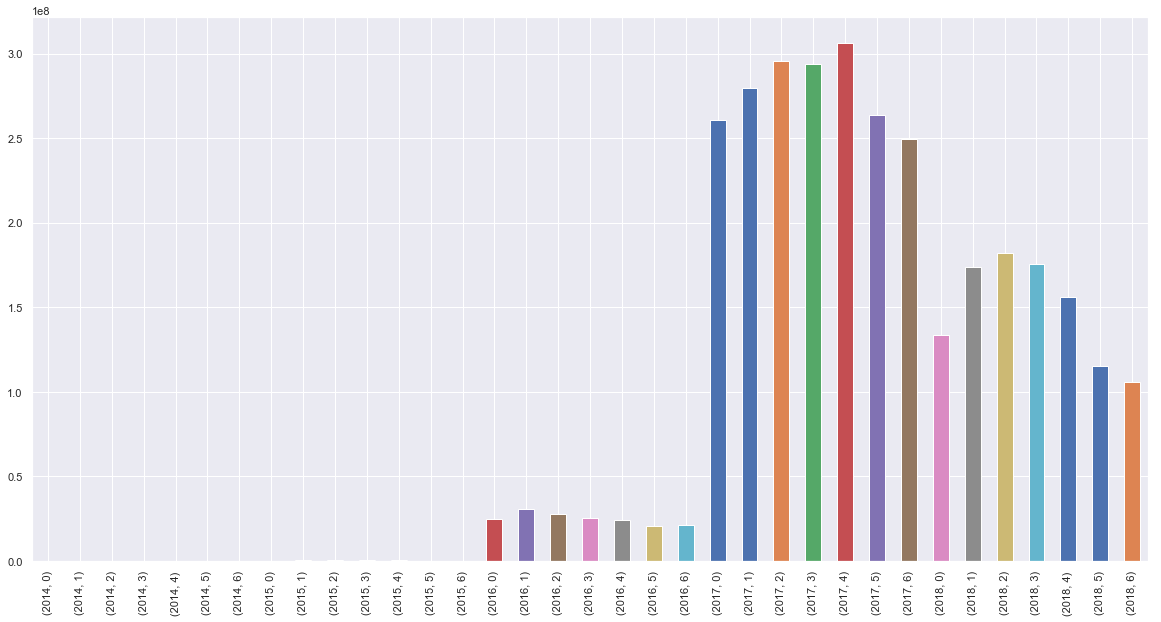

In [211]:
total_volume = volume.T.sum()
total_volume.index = pd.to_datetime(total_volume.index)
total_volume.groupby([total_volume.index.year, total_volume.index.weekday]).mean().plot(kind='bar')

In [ ]:
da

- Correlation
 - You should always try and have a portfolio where assets are as diversified as possible.


 - rolling volatility of returns
 - correlation
 - cointegration
 

In [191]:
prices = pd.DataFrame()
for market in trades:
    baseAsset, quoteAsset = market.split('_')
    data = trades[market]
    prices[market] = data.close
    #timeFrame = prices[market].index
    #basePrice = get_daily_trades(baseAsset, from_file=True).close[timeFrame.min():timeFrame.max()]
    #prices[market] = prices[market] if baseAsset == 'USDT' else prices[market] * basePrice 

In [195]:
prices.shape

(151476, 23)

In [214]:
daily_prices = prices.groupby(prices.index.date).mean()

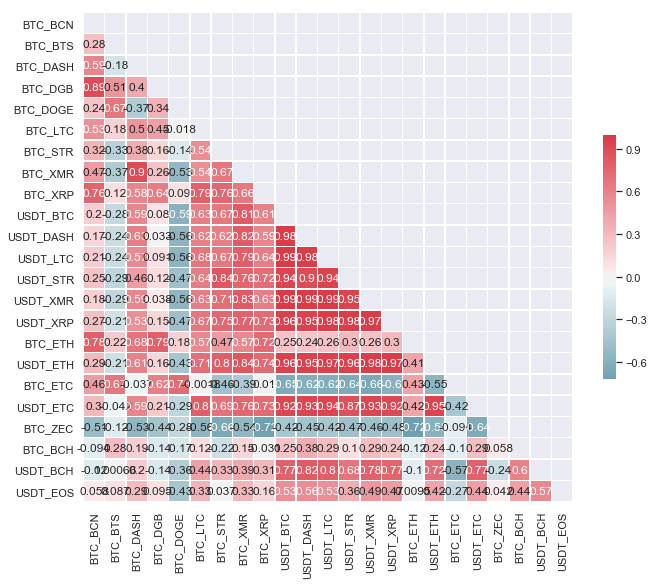

In [193]:
plot.corr(prices.rolling(4 * 12).mean().corr(), annot=True)

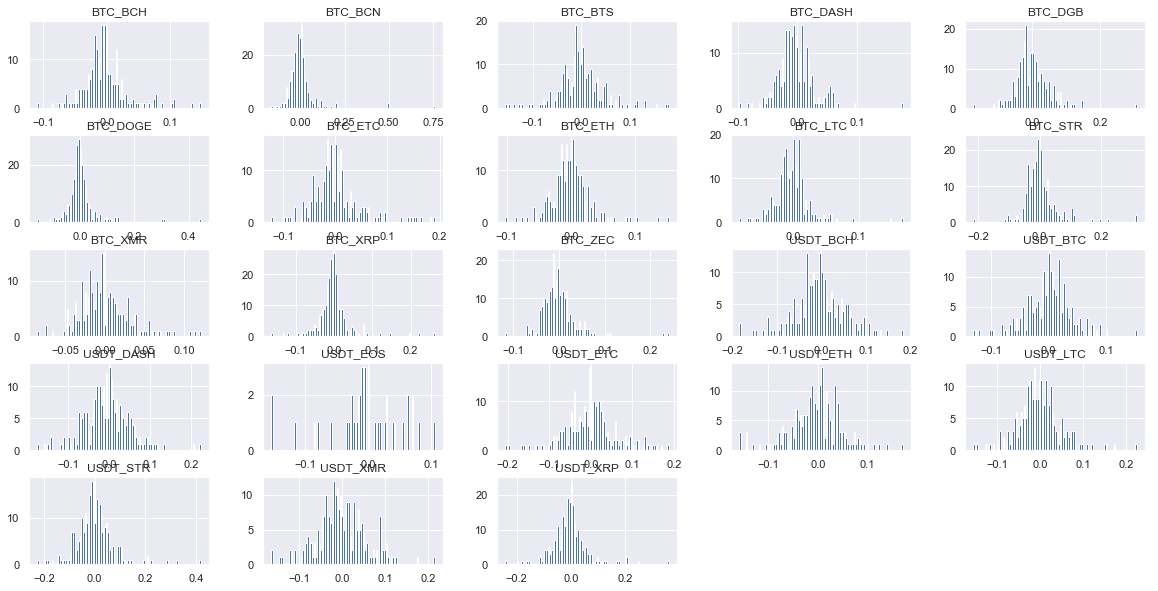

In [254]:
daily_returns = daily_prices.pct_change(1)
daily_returns_18 = daily_returns[date(2018,1,1):]
_ = daily_returns_18.hist(bins=100)

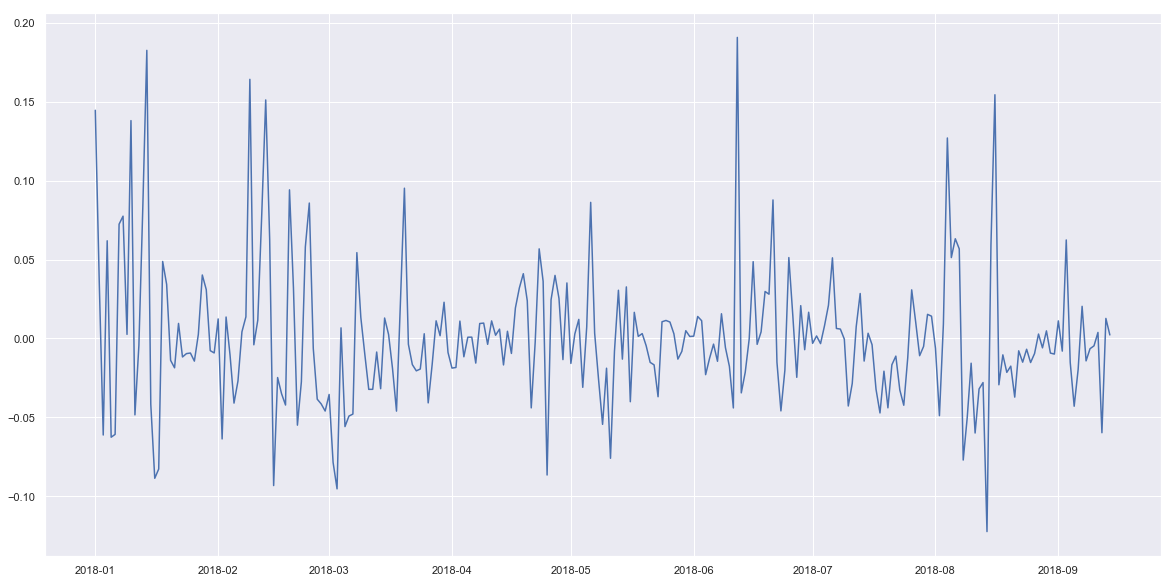

In [272]:
daily_returns_18.BTC_ETC.plot()

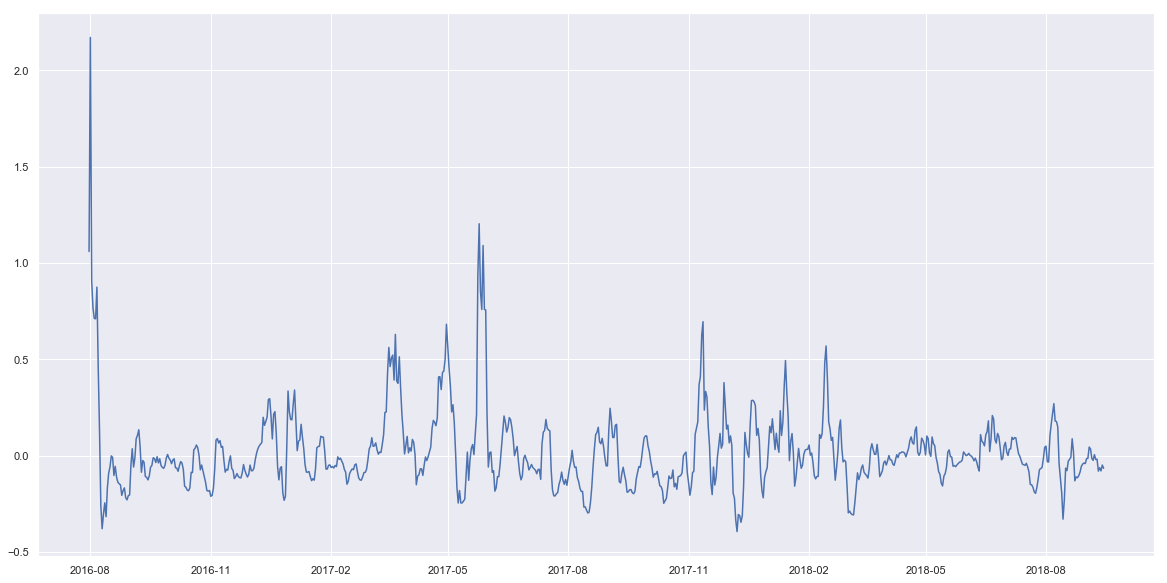

In [277]:
daily_prices.pct_change(7).BTC_ETC.plot()

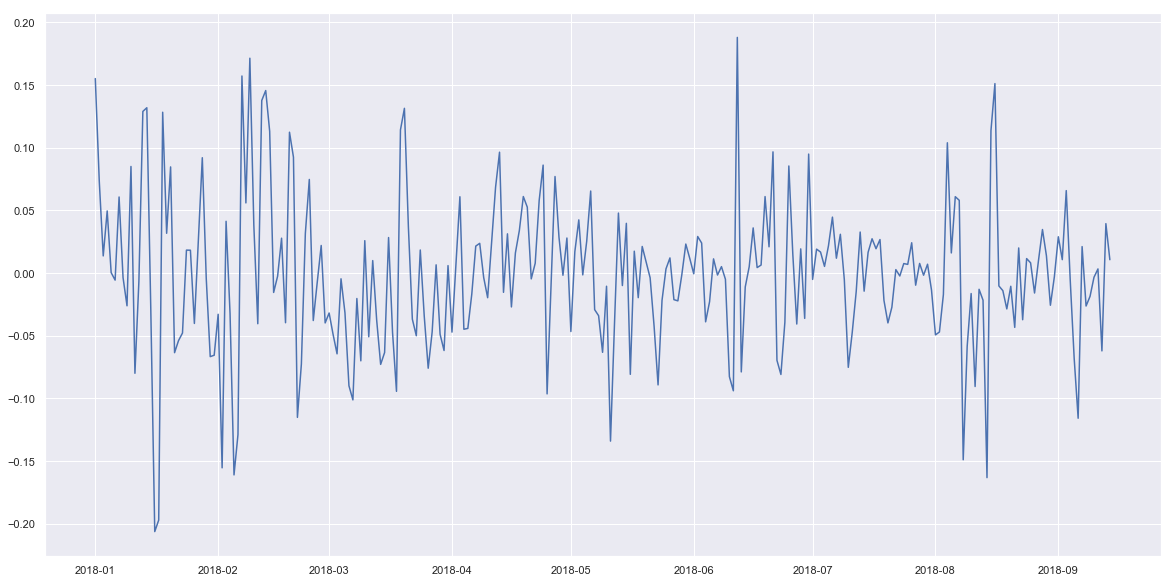

In [276]:
daily_returns_18.USDT_ETC.plot()

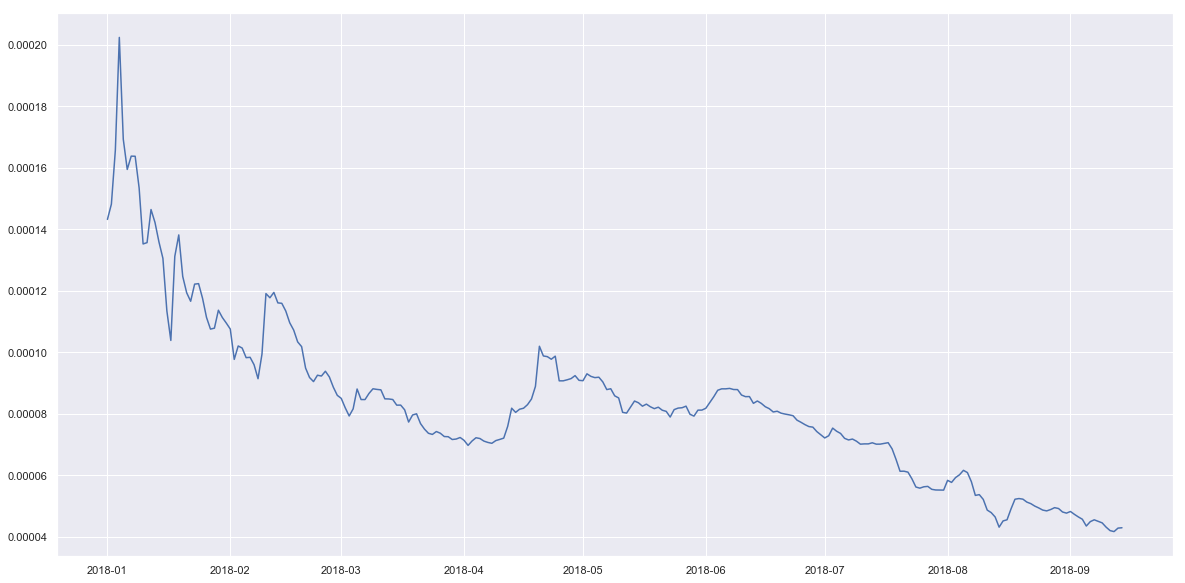

In [275]:
daily_prices[date(2018,1,1):].BTC_XRP.plot()

In [271]:
daily_returns_18.describe().T

,count,mean,std,min,25%,50%,75%,max
BTC_BCN,257.0,0.001200,0.082279,-0.166904,-0.033256,-0.008313,0.014766,0.761782
BTC_BTS,257.0,-0.002856,0.047922,-0.156259,-0.030079,-0.006840,0.019165,0.179721
BTC_DASH,257.0,-0.003168,0.030207,-0.097746,-0.019294,-0.005723,0.010218,0.176520
BTC_DGB,257.0,-0.000048,0.049186,-0.173451,-0.027171,-0.004119,0.022460,0.307796
BTC_DOGE,257.0,0.003090,0.055253,-0.157783,-0.018713,-0.003677,0.015523,0.444820
BTC_LTC,257.0,-0.002267,0.027009,-0.081894,-0.014680,-0.002837,0.008695,0.167235
BTC_STR,257.0,0.002245,0.052972,-0.215593,-0.024095,-0.004596,0.019044,0.315220
BTC_XMR,257.0,-0.000850,0.030346,-0.085449,-0.019606,-0.004069,0.013742,0.121306
BTC_XRP,257.0,-0.003839,0.042153,-0.163633,-0.019325,-0.005509,0.005908,0.263312
USDT_BTC,257.0,-0.001995,0.039169,-0.131536,-0.025759,-0.000029,0.018960,0.153663


#### Downside volatility

In [266]:
((daily_returns_18.mean() -  daily_returns_18.quantile(.25))/daily_returns_18.std()).sort_values()

USDT_EOS     0.313519
BTC_XRP      0.367376
BTC_DOGE     0.394605
BTC_BCN      0.418773
USDT_XRP     0.442549
BTC_LTC      0.459564
BTC_ETC      0.468654
BTC_ETH      0.469772
BTC_BCH      0.485835
BTC_STR      0.497251
USDT_LTC     0.505053
USDT_STR     0.511055
USDT_BCH     0.517817
BTC_ZEC      0.527985
BTC_DASH     0.533842
BTC_DGB      0.551416
USDT_DASH    0.558507
BTC_BTS      0.568060
USDT_ETH     0.578209
USDT_ETC     0.592814
USDT_BTC     0.606704
USDT_XMR     0.608412
BTC_XMR      0.618069
dtype: float64

#### Upside volatility 

In [269]:
((daily_returns_18.quantile(.75) - daily_returns_18.mean())/daily_returns_18.std()).sort_values(ascending=False)


USDT_EOS     0.607145
USDT_BCH     0.582800
USDT_XMR     0.565360
USDT_DASH    0.560063
USDT_ETH     0.536341
USDT_BTC     0.534988
USDT_LTC     0.525830
BTC_XMR      0.480859
BTC_BTS      0.459531
BTC_DGB      0.457613
USDT_ETC     0.454188
BTC_DASH     0.443128
USDT_STR     0.425254
BTC_ETH      0.423056
BTC_ZEC      0.409230
BTC_LTC      0.405888
BTC_BCH      0.392716
USDT_XRP     0.366001
BTC_STR      0.317119
BTC_ETC      0.289695
BTC_XRP      0.231208
BTC_DOGE     0.225013
BTC_BCN      0.164880
dtype: float64

In [262]:
daily_returns_18.std()

BTC_BCN      0.082279
BTC_BTS      0.047922
BTC_DASH     0.030207
BTC_DGB      0.049186
BTC_DOGE     0.055253
BTC_LTC      0.027009
BTC_STR      0.052972
BTC_XMR      0.030346
BTC_XRP      0.042153
USDT_BTC     0.039169
USDT_DASH    0.054122
USDT_LTC     0.050384
USDT_STR     0.074040
USDT_XMR     0.055751
USDT_XRP     0.062962
BTC_ETH      0.030384
USDT_ETH     0.050399
BTC_ETC      0.044965
USDT_ETC     0.061716
BTC_ZEC      0.036412
BTC_BCH      0.033622
USDT_BCH     0.055918
USDT_EOS     0.054780
dtype: float64

In [250]:
daily_returns[date(2018,1,1):].describe().T

,count,mean,std,min,25%,50%,75%,max
BTC_BCN,257.0,0.001200,0.082279,-0.166904,-0.033256,-0.008313,0.014766,0.761782
BTC_BTS,257.0,-0.002856,0.047922,-0.156259,-0.030079,-0.006840,0.019165,0.179721
BTC_DASH,257.0,-0.003168,0.030207,-0.097746,-0.019294,-0.005723,0.010218,0.176520
BTC_DGB,257.0,-0.000048,0.049186,-0.173451,-0.027171,-0.004119,0.022460,0.307796
BTC_DOGE,257.0,0.003090,0.055253,-0.157783,-0.018713,-0.003677,0.015523,0.444820
BTC_LTC,257.0,-0.002267,0.027009,-0.081894,-0.014680,-0.002837,0.008695,0.167235
BTC_STR,257.0,0.002245,0.052972,-0.215593,-0.024095,-0.004596,0.019044,0.315220
BTC_XMR,257.0,-0.000850,0.030346,-0.085449,-0.019606,-0.004069,0.013742,0.121306
BTC_XRP,257.0,-0.003839,0.042153,-0.163633,-0.019325,-0.005509,0.005908,0.263312
USDT_BTC,257.0,-0.001995,0.039169,-0.131536,-0.025759,-0.000029,0.018960,0.153663


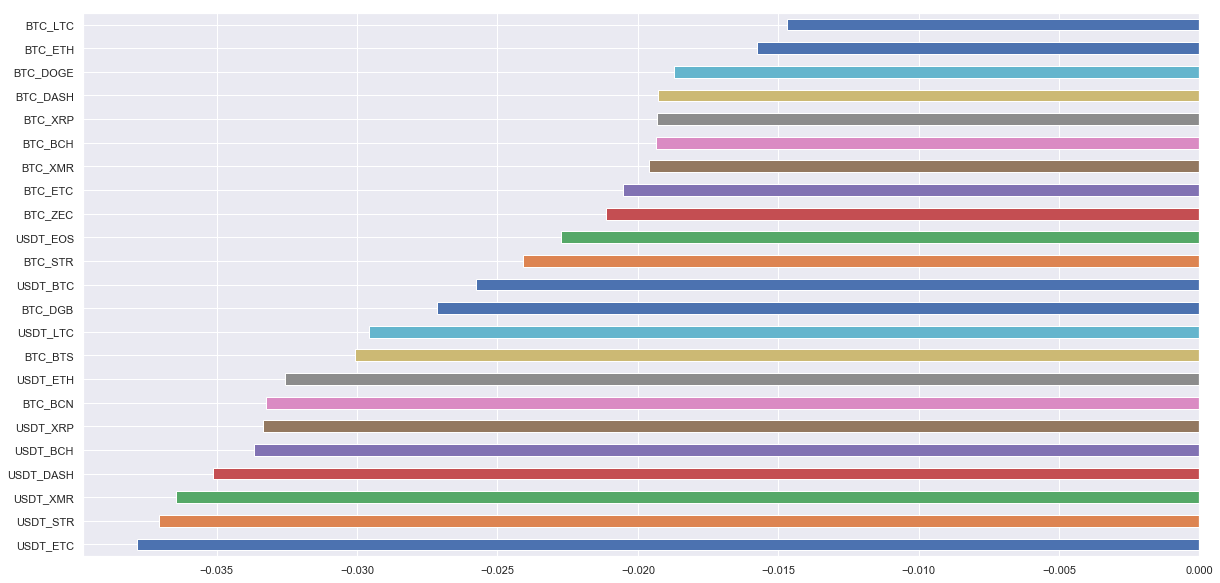

In [253]:
daily_returns[date(2018,1,1):].quantile(.25).sort_values().plot(kind='barh')

In [234]:
volatility = daily_returns.rolling(7).std()
volatility.index = pd.to_datetime(volatility.index)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x169115eb8>,
      dtype=object)

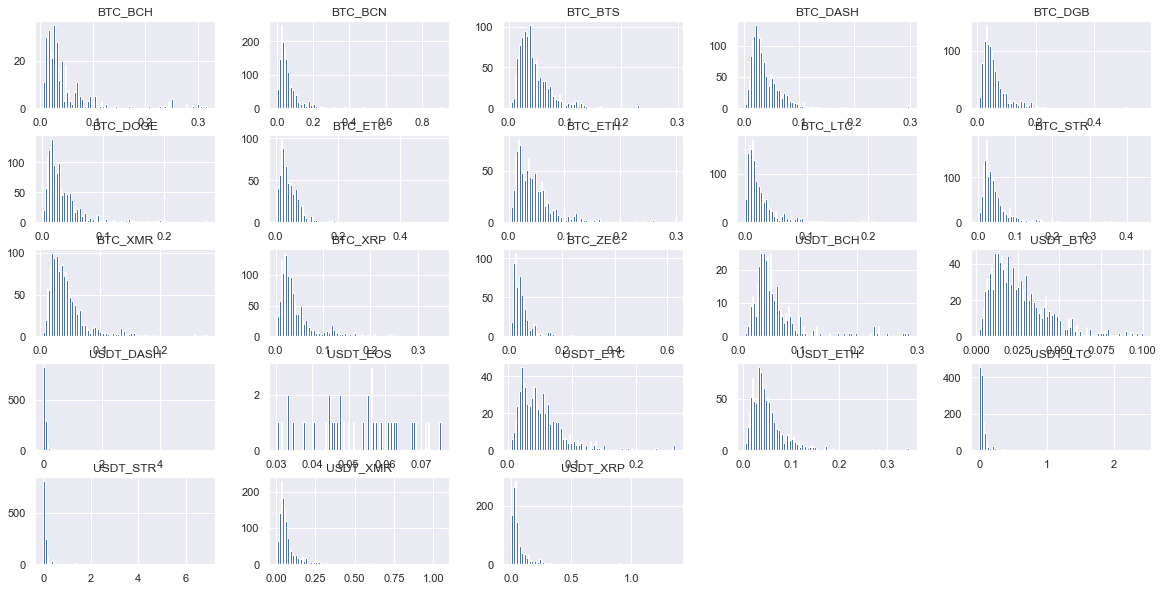

In [223]:
volatility.hist(bins=100)

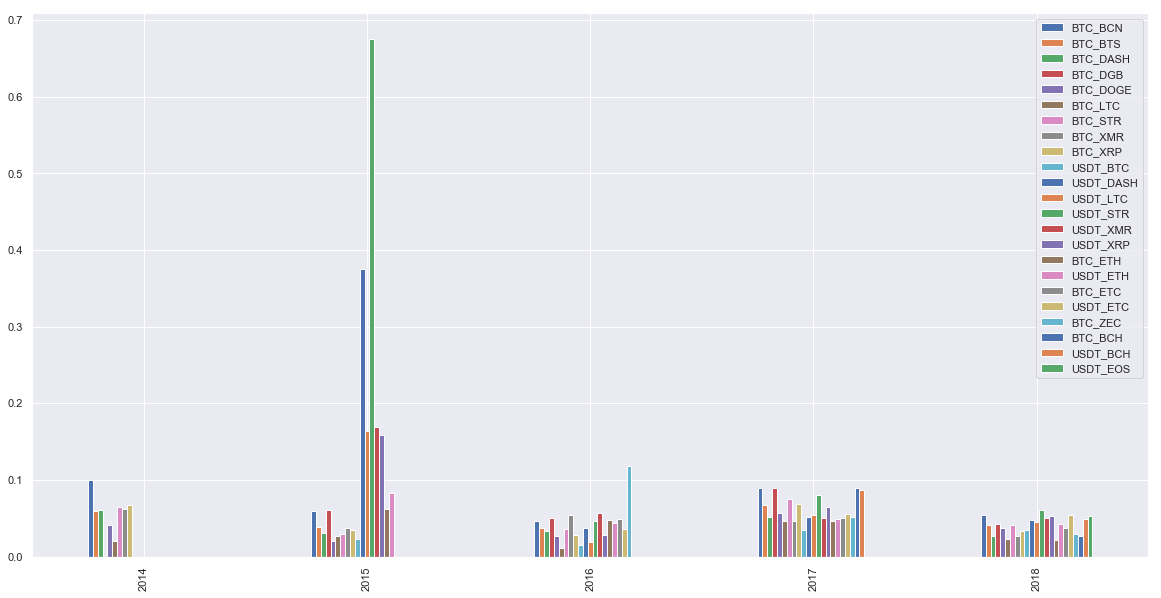

In [238]:
volatility.groupby(volatility.index.year).mean().plot(kind='bar')

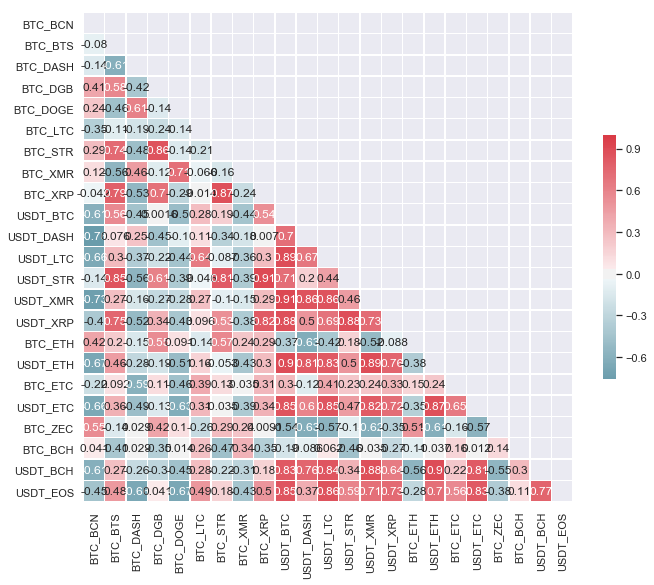

In [242]:
plot.corr(volatility[datetime(2018,1,1):].corr(), annot=True)#plot()

No handles with labels found to put in legend.


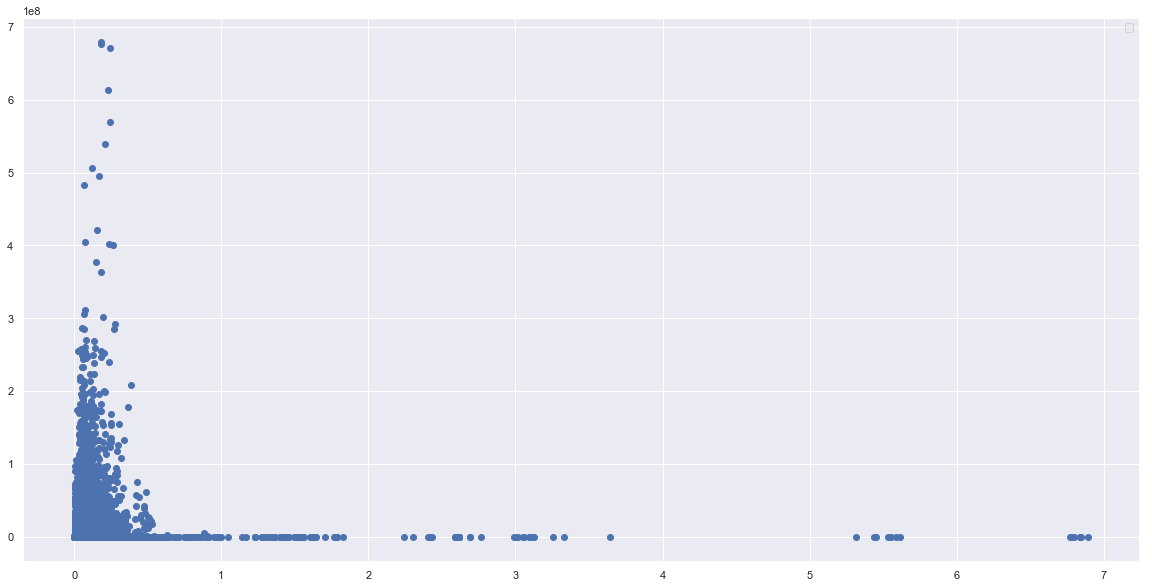

In [244]:
plt.scatter(volatility, volume)
plt.legend()

In [ ]:
sns.pairplot()

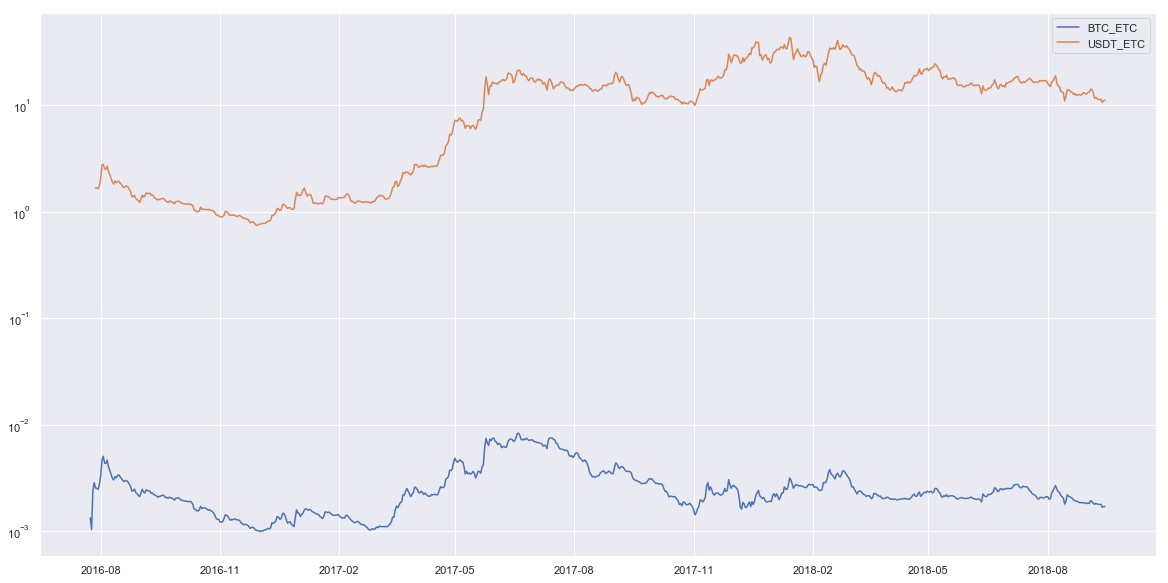

In [217]:
daily_prices.BTC_ETC.plot(logy=True)
daily_prices.USDT_ETC.plot()
plt.legend()

- Costs
 - Cheaper is better. Expensive instruments will need to be traded more slowly, and may be too pricey to trade at all. 

- Skew
 - Assets with strong negative skew need careful handling and shouldn't dominate your portfolio. Using the right trading rules can improve skew to some degree.

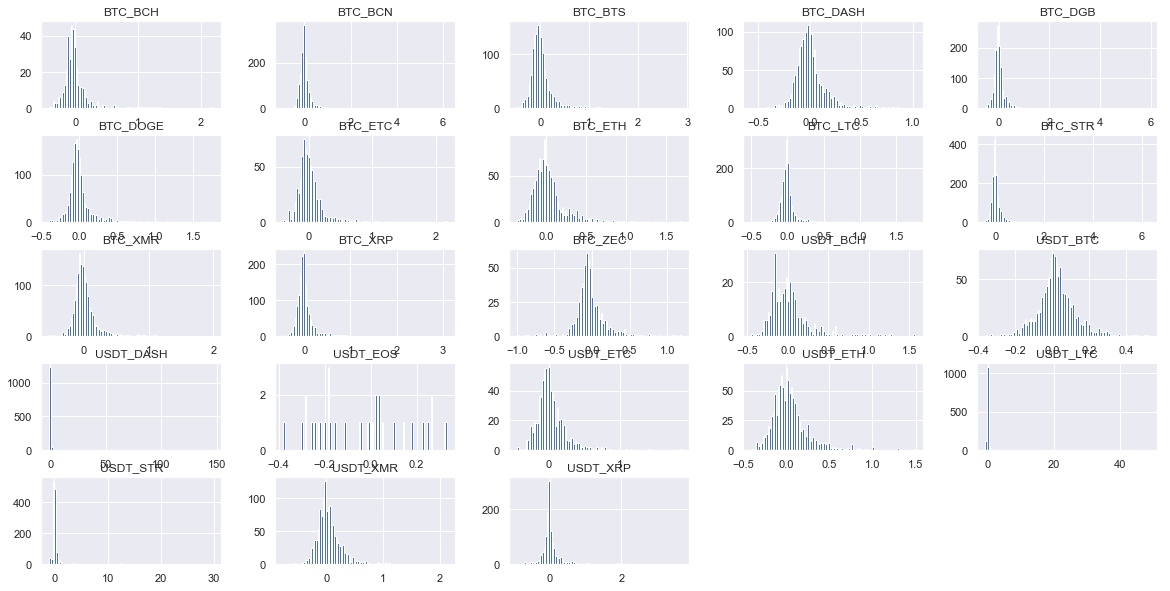

In [190]:
_ = prices.pct_change(7).hist(bins=100)

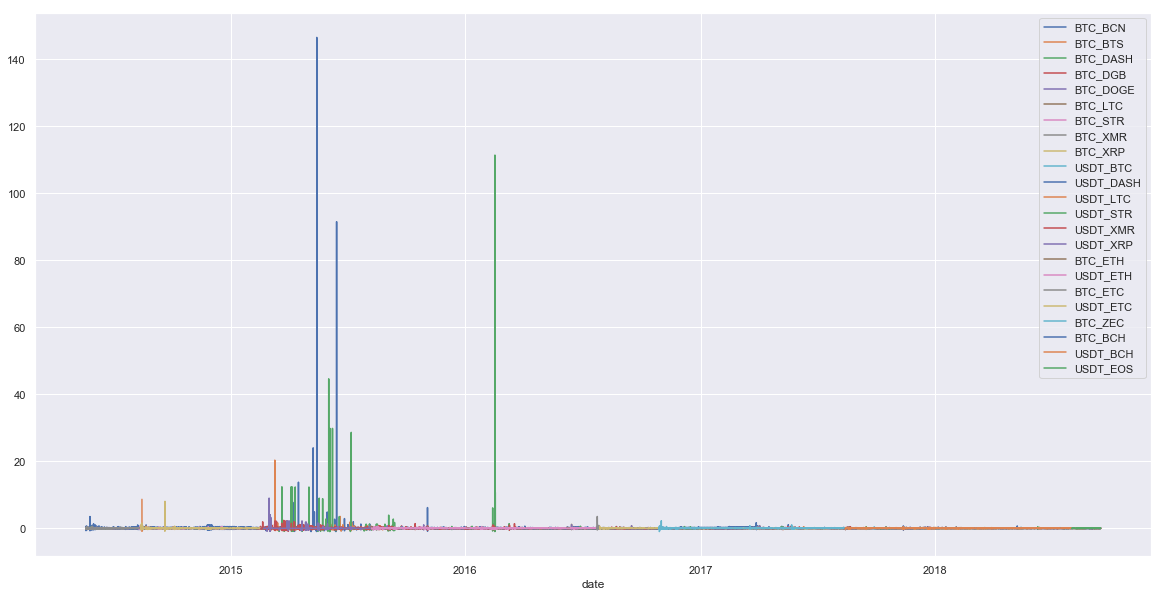

In [278]:
prices.pct_change(7).plot()

### Access
- Trading venue
 - Is the market accessed via exchange, or over the counter? On exchange is preferable.
- Cash or derivative
 - Should you trade the asset outright, or a derivative based on its value, and if so which one?
- Funds
 - Investments through collective funds can make sense when derivatives can't be used. 